# Apartment Sale Listings Analysis

You have access to data from the Yandex Real Estate service — an archive of apartment sale listings in St. Petersburg and nearby localities over several years. The goal is to learn to determine the market value of real estate objects. For this, perform exploratory data analysis and identify the parameters that influence the price of properties. This will allow you to build an automated system to track anomalies and fraudulent activities.

For each apartment for sale, two types of data are available. The first is entered by the user, the second is obtained automatically based on mapping data. For example, the distance to the center, airport, and other objects — this data is automatically obtained from geoservices. The number of parks and bodies of water is also filled in without user participation.

**Project goal:** In this work, we process real estate sales statistics to find out which parameters affect the value of properties and how significant their contribution is.

### Data description:

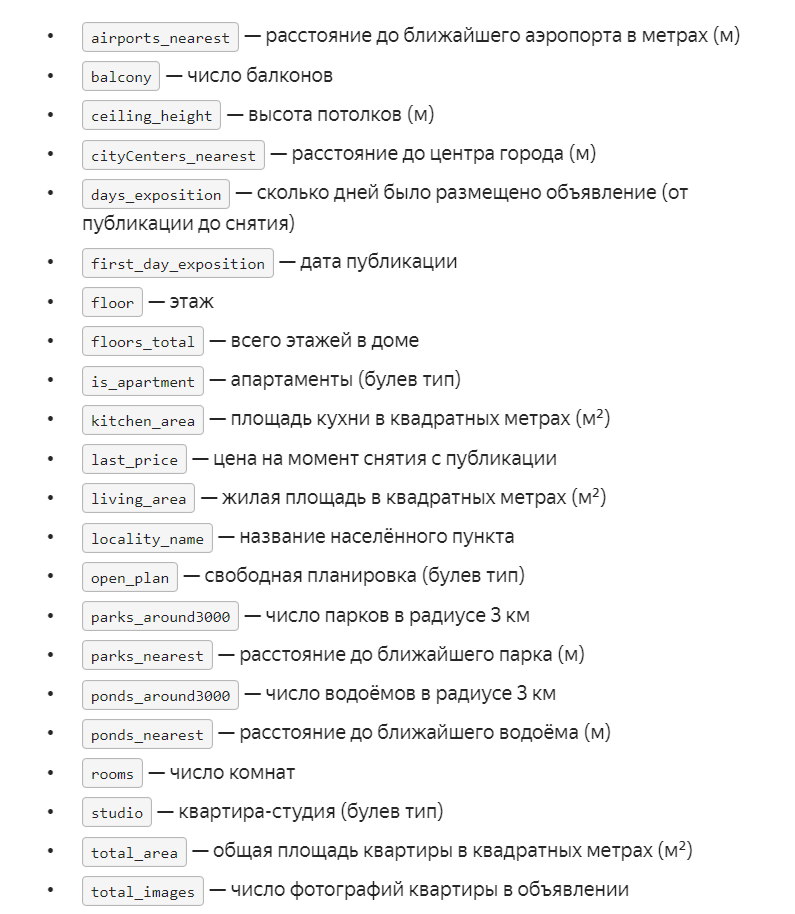

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**A large number of missing values are immediately noticeable in different columns, and the publication date is not of datetime type**

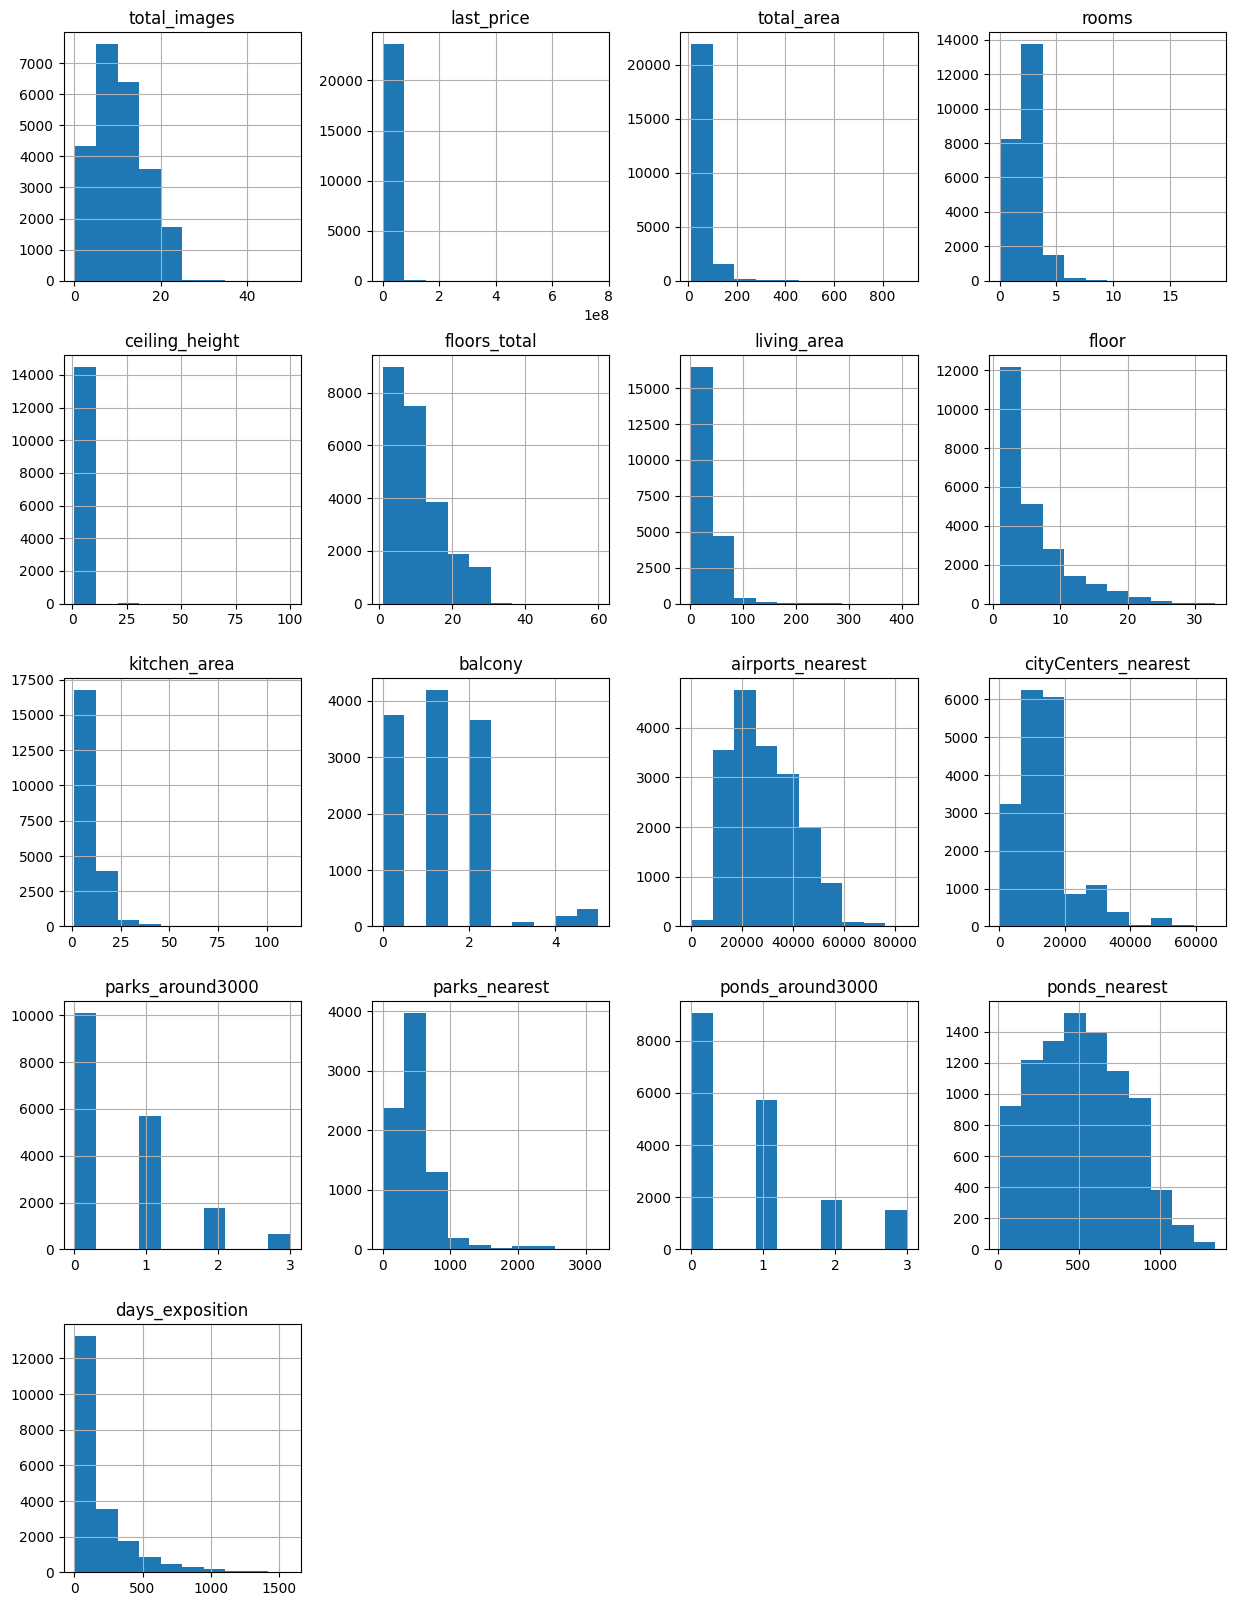

In [5]:
data.select_dtypes(include='number').hist(figsize=(15, 20))
print()

**The data contains 23699 objects, as well as 14 columns with missing values. An obvious error is that the data type in the first_day_exposition column is not Datetime, but object, which needs additional formatting.**

### Data preprocessing

#### Missing values

In [6]:
data.isna().any() #List of columns with missing values

total_images            False
last_price              False
total_area              False
first_day_exposition    False
rooms                   False
ceiling_height           True
floors_total             True
living_area              True
floor                   False
is_apartment             True
studio                  False
open_plan               False
kitchen_area             True
balcony                  True
locality_name            True
airports_nearest         True
cityCenters_nearest      True
parks_around3000         True
parks_nearest            True
ponds_around3000         True
ponds_nearest            True
days_exposition          True
dtype: bool

array([3, 1, 2, 0, 4, 7, 5, 6, 8, 9], dtype=int64)

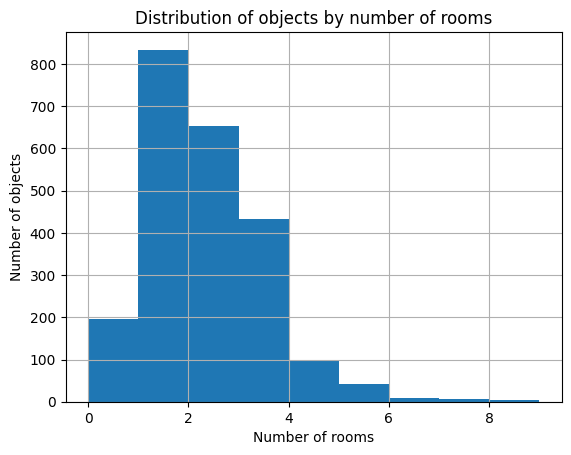

In [7]:
plt.xlabel('Number of rooms')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by number of rooms')
data[data['kitchen_area'].isna()]['rooms'].hist(bins=9)
data[data['kitchen_area'].isna()]['rooms'].unique() 

**It is clear that missing values in kitchen area are unlikely to be due to its absence; in multi-room apartments it is usually present**

In [8]:
data[data['floors_total'].isna()].groupby('locality_name')['locality_name'].count()

locality_name
Красное Село                        2
Кудрово                             2
Санкт-Петербург                    70
городской посёлок Новоселье         1
деревня Новое Девяткино             1
поселок Мурино                      2
поселок городского типа Токсово     1
посёлок Бугры                       1
посёлок Мурино                      2
посёлок Стрельна                    1
посёлок Шушары                      1
посёлок Щеглово                     1
Name: locality_name, dtype: int64

**It is possible that missing values in the number of floors could mean only one floor in private houses. To check this, let's look at their location distribution. There are more private houses outside the city, in villages and settlements, but the vast majority of properties with missing floors are located in the city, and in other locations there are also multi-storey buildings. Since the share of objects with missing values is small, we will remove them from the dataset.**

In [9]:
print(data['days_exposition'].max()) #Check the longest listing that was then removed from the site
data[data['days_exposition'].isna()]['first_day_exposition'].tail()

1580.0


23684    2018-11-02T00:00:00
23685    2019-01-24T00:00:00
23694    2017-03-21T00:00:00
23696    2018-02-11T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, dtype: object

**So far, the data has not been converted to datetime format, but we can draw some conclusions. Most likely, the column with the number of days the listing was posted before it was removed was filled in automatically, and NaN values mean that at the time of data collection, the listing was still active. Therefore, we could fill in the missing values with the difference in days between the current date and the value in first_day_exposition. However, this may distort further processing and analysis (listings still active at the time of data collection would appear to have been posted for many years). The maximum value of days_exposition is 1580/365=4.33 years, which is much less than the 5-6 years we would get based on the current date. It would be more plausible to take the date of data collection as the current date, but it is not given, so we will find either the newest posted listing with NaN in days_exposition or the newest listing among those already removed and add the duration of posting to it, whichever date is the most recent, we will take as the data collection date.
After performing the above manipulations, it became clear that replacing missing values in this column would distort the statistics for listings that were actually sold, as it may turn out that a fresh unsuccessful listing appears to have been sold quickly, which distorts further reasoning.**

**Let's discuss missing values in automated data that were not entered by the user. Most likely, NaN values in the number of parks and ponds mean that there are simply none nearby, so they should be replaced with 0. We will leave the distances to such objects as missing, as replacing them with 0 would not make sense. Missing values in the number of balconies will be replaced with 0, most likely balconies are simply absent.**

**Separately, let's mention is_apartment, which is filled in by the user. Apartments are a special type of real estate. Legally, an apartment is residential property, while apartments are commercial (non-residential). They are intended for temporary stay, not permanent residence. Therefore, laws, requirements, and standards for apartments and residential premises differ. Based on this, the authors of the listings would hardly omit this important parameter when selling apartments. Therefore, we can replace all missing values with False.**

**Summary of missing value processing**:
1. ceiling_height - standardized value, replace with median
1. floors_total - remove rows with missing values
1. living_area - leave missing values 
1. is_apartment - replace with False
1. kitchen_area - leave missing values
1. balcony - replace with 0
1. locality_name - remove rows with missing values
1. airports_nearest - leave missing values
1. cityCenters_nearest - leave missing values
1. parks_around3000 - replace with 0
1. parks_nearest - leave missing values
1. ponds_around3000 - replace with 0
1. ponds_nearest  - leave missing values
1. days_exposition - possible replacement described above, leave missing values

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data[['parks_around3000','balcony','ponds_around3000']] = data[['parks_around3000','balcony','ponds_around3000']].fillna(0)
data = data.dropna(subset=['floors_total', 'locality_name'])
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

C:\Users\datre\AppData\Local\Temp\ipykernel_25252\1306878122.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


We will process missing values in days_exposition after converting its data type to datetime

In [11]:
data.info() #intermediate check

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest      18

**Possible reasons for missing data**:
1. ceiling_height - not specified by user, possibly difficult to measure
1. floors_total - not specified by user
1. living_area - not specified by user, possibly difficult to measure
1. is_apartment - not specified by user, missing values handled in preprocessing
1. kitchen_area - not specified by user, possibly difficult to measure
1. balcony - not specified by user, missing values handled in preprocessing
1. locality_name - not specified by user, possibly property is outside settlements (e.g., a house in the forest)
1. airports_nearest - filled automatically, most likely the nearest airport is quite far
1. cityCenters_nearest - filled automatically, most likely the nearest center is quite far or the settlement is small and does not have a clearly defined center
1. parks_around3000 - filled automatically, most likely there are no parks nearby, missing values handled in preprocessing
1. parks_nearest - filled automatically, most likely the nearest park is quite far
1. ponds_around3000 - filled automatically, most likely there are no ponds nearby, missing values handled in preprocessing
1. ponds_nearest - filled automatically, most likely the nearest pond is quite far
1. days_exposition - most likely the column with the number of days the listing was posted before it was removed was filled in automatically, and NaN values mean that at the time of data collection, the listing was still active

#### Data types

**During processing, we noticed only one data type mismatch: the first_day_exposition column contains string values, not datetime, so for convenience in further processing and filling missing values in days_exposition, we will correct it.**

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_exposition'].head() #check

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

**Now we can fill in missing values in first_day_exposition:**

UPD: I shouldn't have written all this, but I won't delete it, I'll leave it commented out

In [13]:
"""
id_max_na = (
    data[data['days_exposition'].isna()]
    .query('first_day_exposition == first_day_exposition.max()')
    .index
)

id_max = (
    data[~data['days_exposition'].isna()]
    .query('first_day_exposition == first_day_exposition.max()')
    .index
)
#repeated max() get values from series
approx_curr_date = max(
    data.iloc[id_max_na]['first_day_exposition'].max(),
    data.iloc[id_max]['first_day_exposition'].max() + pd.Timedelta(days=data.iloc[id_max]['days_exposition'].values[0])
)
approx_curr_date #approximate data collection date
"""
print()

In [14]:
"""
data['days_exposition'] = data['days_exposition'].fillna(
   (approx_curr_date - data[data['days_exposition'].isna()]['first_day_exposition']).dt.days
)
data['days_exposition']
"""
print()

**It can also be seen that the data type is float in integer parameters with replaced missing values: parks_around3000, ponds_around3000, balcony. Where missing values remain, conversion to int is not possible. Such a replacement will save some memory when storing the dataset and is more intuitive, the number of parks/balconies/ponds nearby is quite small and integer. When comparing the memory usage summary in the info() method, we get a 0.5 MB gain from such a simple replacement.**

In [15]:
data[['parks_around3000', 'ponds_around3000', 'balcony', 'floors_total']] = data[['parks_around3000', 'ponds_around3000', 'balcony', 'floors_total']].astype('int8')
data = data.reset_index(drop=True)
data.info() #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int8          
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

#### Duplicates

In [16]:
data.duplicated().sum() #no obvious duplicates found

0

In [17]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')

unique_localities = np.sort(data['locality_name'].unique())
unique_groups = []
for locality in unique_localities:
    result = [loc for loc in unique_localities if locality.split()[-1] in loc.split()[-1]]
    unique_groups.append(result)
unique_groups

[['Бокситогорск'],
 ['Волосово'],
 ['Волхов'],
 ['Всеволожск'],
 ['Выборг'],
 ['Высоцк', 'село Русско-Высоцкое'],
 ['Гатчина'],
 ['Зеленогорск'],
 ['Ивангород'],
 ['Каменногорск'],
 ['Кингисепп', 'поселок Кингисеппский'],
 ['Кириши'],
 ['Кировск'],
 ['Колпино'],
 ['Коммунар', 'поселок Коммунары'],
 ['Красное Село'],
 ['Кронштадт'],
 ['Кудрово', 'деревня Кудрово'],
 ['Лодейное Поле'],
 ['Ломоносов'],
 ['Луга', 'поселок Усть-Луга'],
 ['Любань', 'поселок Любань'],
 ['Мурино', 'поселок Мурино'],
 ['Никольское', 'село Никольское'],
 ['Новая Ладога', 'село Старая Ладога'],
 ['Отрадное'],
 ['Павловск'],
 ['Петергоф'],
 ['Пикалево'],
 ['Подпорожье'],
 ['Приморск'],
 ['Приозерск'],
 ['Пушкин'],
 ['Санкт-Петербург'],
 ['Светогорск'],
 ['Сертолово'],
 ['Сестрорецк'],
 ['Сланцы'],
 ['Сосновый Бор',
  'деревня Бор',
  'деревня Трубников Бор',
  'деревня Чудской Бор',
  'поселок Пансионат Зеленый Бор',
  'поселок городского типа Красный Бор'],
 ['Сясьстрой'],
 ['Тихвин'],
 ['Тосно'],
 ['Шлиссельбург

**Let's roughly estimate implicit duplicates. Of course, grouping by the last word in the locality name is not ideal, but it gives a general idea of what should be replaced. For example, replace all urban-type settlements, urban settlements, and villages with just settlements. You can also notice duplicates in Murino, which can simply be replaced with Murino. Villages are not settlements and are different types of localities. There may be other duplicates that I did not notice due to my limited geographical knowledge (and not only knowledge, almost everything was googled).**

In [18]:
words_to_remove = ['urban', 'urban', 'type', 'at', 'railway']
duplicate_ids = []
for id in data['locality_name'].index:
    str_splitted = data.iloc[id]['locality_name'].split(sep=' ')
    for word in str_splitted:
        if word in words_to_remove or word == 'village':
            duplicate_ids.append(id) #to avoid iterating over the entire dataset, take the ids of duplicates
            
for id in duplicate_ids:
    str_splitted = data.iloc[id]['locality_name'].split(sep=' ')
    for word in str_splitted:
        if word in words_to_remove:
            str_splitted.remove(word)
        elif word == 'village':
            str_splitted[0] = 'settlement'
    data.loc[id, 'locality_name'] = ' '.join(str_splitted)

In [19]:
data['locality_name'] = data['locality_name'].str.replace('settlement Murino', 'Murino')

In [20]:
np.sort(data[~data['locality_name'].isna()]['locality_name'].unique()) #check

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской поселок Фед

In the "data preprocessing" section, we analyzed missing values and their possible causes, replaced them with the most plausible values where possible. Changed the data type in columns with integer values from float to int, represented the listing date in datetime format. Many implicit duplicates were also found, related to different spellings of the same localities. Based on this, I can recommend the service where the listings were posted to specify the locality not manually, but by selecting a point on the map, so there will be no confusion with names.

### Add new columns to the table

#### Price per square meter

In [21]:
data['sq_mt_price'] = (data['last_price'] / data['total_area']).round(2)
data['sq_mt_price'].head()

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: sq_mt_price, dtype: float64

#### Day of the week the listing was posted

In [22]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['weekday_exposition'].head()

0    3
1    1
2    3
3    4
4    1
Name: weekday_exposition, dtype: int32

#### Month of the listing

In [23]:
data['month_exposition'] = data['first_day_exposition'].dt.month
data['month_exposition'].head()

0     3
1    12
2     8
3     7
4     6
Name: month_exposition, dtype: int32

#### Year of the listing

In [24]:
data['year_exposition'] = data['first_day_exposition'].dt.year
data['year_exposition'].head()

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_exposition, dtype: int32

#### Floor type

In [25]:
data['floor_type'] = 'other'
data['floor_type'] = (
    data['floor_type']
    .where(data['floors_total'] != data['floor'], 'last')
    .where(data['floor'] != 1, 'first')
)
data['floor_type']

0        other
1        first
2        other
3        other
4        other
         ...  
23560    other
23561    other
23562    first
23563    other
23564    first
Name: floor_type, Length: 23565, dtype: object

#### Distance to city center in kilometers

In [26]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round()
data['cityCenters_nearest_km']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23560     4.0
23561     NaN
23562     NaN
23563    10.0
23564     NaN
Name: cityCenters_nearest_km, Length: 23565, dtype: float64

### Exploratory data analysis

#### Building histograms and searching for outliers

##### total_area

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

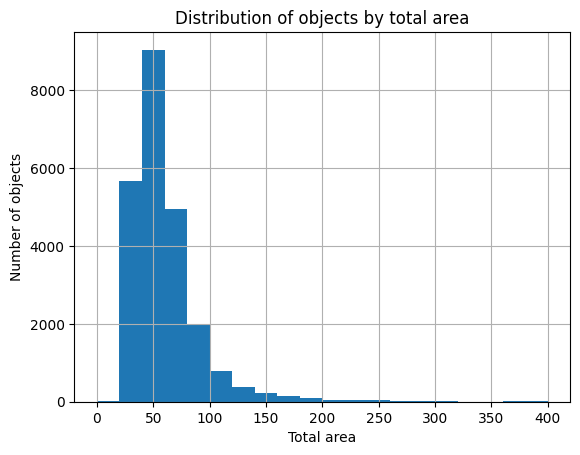

In [27]:
plt.xlabel('Total area')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by total area')
data['total_area'].hist(bins=20, range=(0,400))
data['total_area'].describe()

In [28]:
data.query('total_area > 250').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_mt_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
155,8,96000000.0,317.0,2017-07-07,4,3.5,3,183.0,3,False,...,508.0,3,366.0,62.0,302839.12,4,7,2017,last,2.0
461,15,66571000.0,280.3,2015-06-11,6,5.2,8,159.5,7,False,...,187.0,1,616.0,578.0,237499.11,3,6,2015,other,7.0
578,20,65000000.0,365.0,2019-03-18,7,2.9,7,NaN,7,False,...,378.0,3,58.0,NaN,178082.19,0,3,2019,last,2.0
657,3,49950000.0,483.9,2017-10-04,7,3.2,6,312.5,4,False,...,461.0,3,22.0,391.0,103223.81,2,10,2017,other,1.0
789,20,135000000.0,310.0,2018-05-22,4,3.3,5,250.0,2,False,...,295.0,3,190.0,342.0,435483.87,1,5,2018,other,7.0


In [29]:
data.query('total_area < 15')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_mt_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
17859,3,1400000.0,13.0,2017-12-03,1,2.60,9,NaN,1,False,...,NaN,1,185.0,410.0,107692.31,6,12,2017,first,16.0
19437,3,1850000.0,13.0,2019-03-11,1,3.40,5,NaN,2,False,...,644.0,0,NaN,24.0,142307.69,0,3,2019,other,5.0
19449,2,1686000.0,13.2,2018-12-17,1,2.65,5,NaN,1,False,...,361.0,1,155.0,19.0,127727.27,0,12,2018,first,4.0
19533,5,1190000.0,14.0,2018-07-29,1,2.65,5,11.0,1,False,...,NaN,0,NaN,4.0,85000.00,6,7,2018,first,11.0
19698,0,3800000.0,13.0,2018-07-04,1,2.65,5,10.0,3,False,...,592.0,3,27.0,9.0,292307.69,2,7,2018,other,1.0
19795,4,2400000.0,12.0,2017-07-19,1,2.55,5,10.0,2,False,...,886.0,2,45.0,200.0,200000.00,2,7,2017,other,1.0


In [30]:
data = data[(data['total_area'] >= 20) & (data['total_area'] <= 200)]

**No outliers were noticed in the total area distribution, we will filter out rarely occurring values total_area<20 and total_area>200**

**Intermediate conclusions on total_area: most apartments have an area up to 100 m^2, the median area is 52 m^2, above which the number of apartments decreases as the area increases. There are a few apartments with a very large area of more than 500 m^2, as well as single objects with a very small area up to 15 m^2.**  

##### living_area

count    21484.000000
mean        33.265165
std         17.365499
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

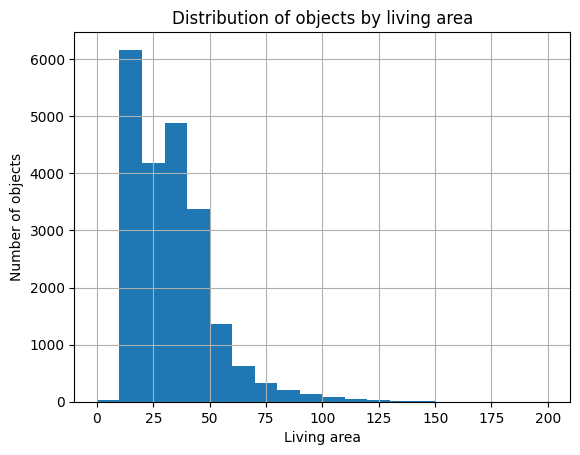

In [31]:
plt.xlabel('Living area')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by living area')
data['living_area'].hist(bins=20, range=(0,200))
data['living_area'].describe()

In [32]:
data.query('living_area > 125').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_mt_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
415,5,14200000.0,178.0,2017-10-26,5,3.30,4,126.6,2,False,...,NaN,3,257.0,104.0,79775.28,3,10,2017,other,3.0
645,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,False,...,NaN,0,NaN,NaN,95264.02,6,7,2018,last,3.0
803,14,18777000.0,181.5,2018-07-25,6,3.60,6,125.1,4,False,...,NaN,1,397.0,204.0,103454.55,2,7,2018,other,5.0
1807,0,15000000.0,179.0,2017-04-09,7,2.65,5,126.4,5,False,...,104.0,1,803.0,15.0,83798.88,6,4,2017,last,3.0
1936,20,16000000.0,184.4,2018-10-21,7,2.65,6,125.7,5,False,...,525.0,1,791.0,109.0,86767.90,6,10,2018,other,3.0


In [33]:
data.query('living_area < 10')[['total_area', 'living_area', 'kitchen_area', 'rooms']].sort_values(by='living_area')

,total_area,living_area,kitchen_area,rooms
21634,23.00,2.0,NaN,0
13837,52.00,2.0,9.0,2
23442,139.00,3.0,16.0,3
3228,41.00,3.0,11.0,1
17483,22.00,5.0,NaN,0
21818,77.60,5.4,9.8,4
16342,31.00,6.0,17.0,1
19144,33.00,6.5,18.0,1
20877,50.60,8.0,31.0,2
23077,37.00,8.0,22.0,1


**The distribution looks quite plausible, most apartments have a living area from 12 to 50 meters. There are no questions about the maximum value, but there are comments on the minimum values. Some listings with a living area up to 10 meters have a fairly large total area and several rooms. Most likely, a mistake was made in the digit when filling in these parameters by the user. Therefore, we will replace the living area values multiplied by 10 in the listings with indices:** 
*21634, 13837, 23442, 3228, 21818* **. The sum of the living area and kitchen area will not exceed the total area. For further analysis, we will discard values with living_area < 10 and living_area > 125 as rarely occurring. There are also missing values in the living area data, but they are few and can be discarded for further analysis**		

**Intermediate conclusions on living_area: most apartments in our dataset have a living area up to 50 m^2, the median living area is 30 m^2, there are single objects with a very large living area of more than 130 m^2, and objects with a very small living area up to 10 m^2. Two peaks on the living area distribution histogram most likely correspond to apartments with different numbers of rooms (1,2,3).**

In [34]:
for id in [21634, 13837, 23442, 3228, 21818]:
    data.loc[id, 'living_area'] = data.loc[id, 'living_area'] * 10

In [35]:
data = data[(data['living_area'] > 10) & (data['living_area'] < 125)]
data.shape[0]

21403

##### kitchen_area

count    20642.000000
mean        10.306773
std          5.289330
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         93.200000
Name: kitchen_area, dtype: float64

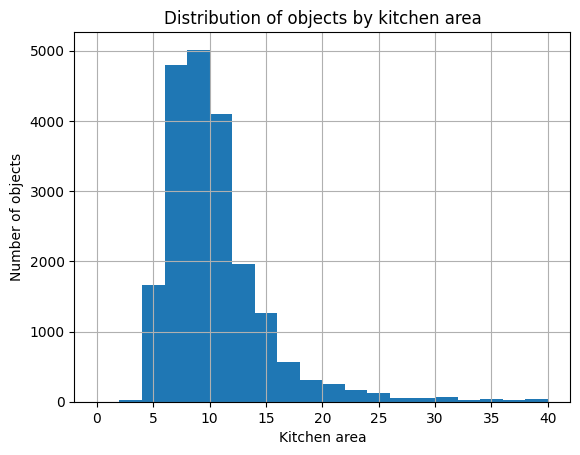

In [36]:
plt.xlabel('Kitchen area')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by kitchen area')
data['kitchen_area'].hist(bins=20, range=(0,40))
data['kitchen_area'].describe()

In [37]:
data.query('kitchen_area > 50').sort_values(by='kitchen_area', ascending=False)['kitchen_area']

16150    93.2
16701    93.0
10807    87.2
4373     77.0
14559    75.0
16552    72.0
18345    65.0
22849    65.0
15693    64.0
17811    64.0
19390    64.0
19024    63.0
14814    62.5
3546     60.0
8220     58.4
20754    58.0
4299     56.2
16941    56.0
10729    56.0
16867    55.7
17464    54.2
20385    53.0
11655    51.8
5990     51.0
8666     51.0
20521    50.2
Name: kitchen_area, dtype: float64

In [38]:
data.query('kitchen_area < 4')[['total_area', 'living_area', 'kitchen_area', 'rooms']].sort_values(by='kitchen_area')

,total_area,living_area,kitchen_area,rooms
20105,28.50,19.5,1.30,1
902,27.00,18.0,2.00,1
16278,25.70,22.6,2.00,1
21298,20.00,14.0,2.00,1
10971,32.00,16.0,2.00,1
9093,23.29,21.0,2.00,1
6229,24.00,16.0,2.00,2
17733,34.70,15.5,2.30,1
7909,66.40,44.4,2.89,2
17327,26.69,17.4,3.00,1


**We will discard small values kitchen_area < 4 and large values kitchen_area > 40 as rare. We will also discard missing values for further analysis**

In [39]:
data = data[(data['kitchen_area'] >= 4) & (data['kitchen_area'] <= 40)]
data.shape[0]

20534

**Intermediate conclusions on kitchen_area: most objects in our dataset have a kitchen area up to 20 m^2, the median value is 9 m^2, after which the number of apartments decreases as the kitchen area increases. There are also single objects with a small kitchen area up to 4 m^2 and objects with a very large kitchen area of more than 50 m^2.**

##### last_price

count    2.053400e+04
mean     5.944449e+06
std      5.882105e+06
min      4.300000e+05
25%      3.499000e+06
50%      4.650000e+06
75%      6.650000e+06
max      3.300000e+08
Name: last_price, dtype: float64

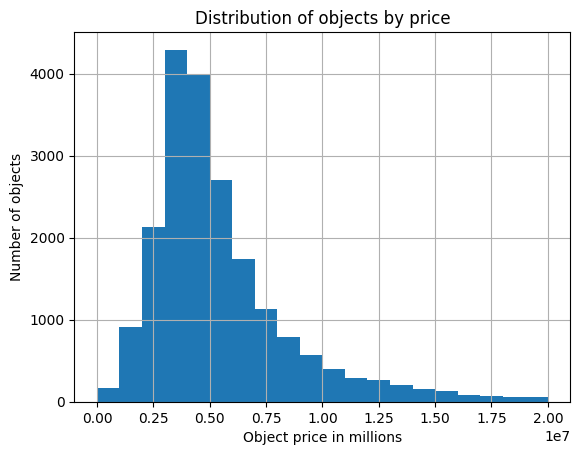

In [40]:
plt.xlabel('Object price in millions')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by price')
data['last_price'].hist(bins=20, range=(0, 20000000))
data['last_price'].describe()

In [41]:
data.sort_values(by='last_price', ascending=True)[['last_price','total_area','rooms']].head(10)

,last_price,total_area,rooms
17359,430000.0,30.4,1
17577,450000.0,36.5,1
5670,450000.0,42.0,2
9535,450000.0,43.4,2
23352,470000.0,44.5,2
18763,470000.0,41.0,1
10722,490000.0,29.1,1
14212,500000.0,34.0,1
2089,500000.0,30.7,1
4384,500000.0,52.0,2


In [42]:
data.sort_values(by='last_price', ascending=False)[['last_price','total_area','rooms']].head(20)

,last_price,total_area,rooms
1431,330000000.0,190.0,3
22701,289238400.0,187.5,2
4971,124000000.0,124.5,4
11977,86738800.0,190.0,5
11362,85000000.0,145.7,3
10306,83820000.0,153.0,3
6428,82000000.0,114.0,3
6778,79000000.0,163.0,6
5205,77612080.0,152.3,2
14412,77000000.0,186.0,3


**We will filter out values last_price > 2e+7**

**Intermediate conclusions on last_price: most objects in our data have a price up to 10 million rubles, the median price is 4.65 million rubles, there are ultra-cheap single options up to 500 thousand rubles and very expensive ones over 50 million rubles. The most expensive option costs 330 million rubles.**

In [43]:
data = data[data['last_price'] < 2e+7]
data.shape[0]

20133

##### rooms

count    20133.000000
mean         2.026375
std          0.945647
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

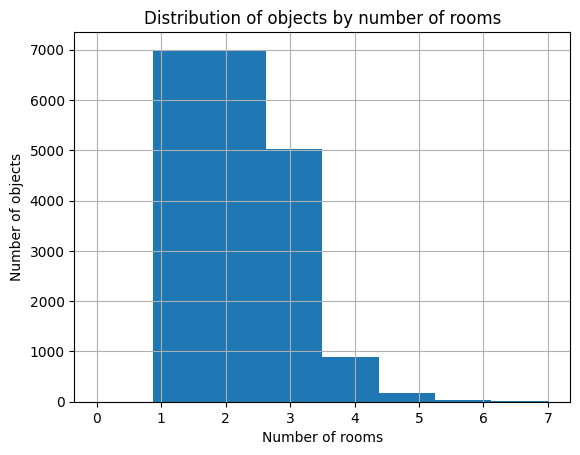

In [44]:
plt.xlabel('Number of rooms')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by number of rooms')
data['rooms'].hist(bins=8, range=(0, 7))
data['rooms'].describe()

In [45]:
data.groupby('rooms')['rooms'].count()

rooms
1    7000
2    7000
3    5016
4     890
5     182
6      37
7       7
8       1
Name: rooms, dtype: int64

In [46]:
data.query('rooms == 6')[['total_area', 'living_area', 'kitchen_area', 'rooms']].head()

,total_area,living_area,kitchen_area,rooms
52,136.0,94.0,11.0,6
200,123.1,89.0,11.0,6
2010,111.0,84.5,10.2,6
2131,140.9,104.1,11.9,6
2634,177.0,115.0,11.0,6


**No comments were found on the number of rooms, possibly anomalous values were filtered out in previous steps indirectly**

**Intermediate conclusions on rooms: in our data, the number of one- and two-room apartments is the same. Most apartments have no more than four rooms, there are single options with seven and eight rooms.**

##### ceiling_height

count    20133.000000
mean         2.712470
std          1.010657
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

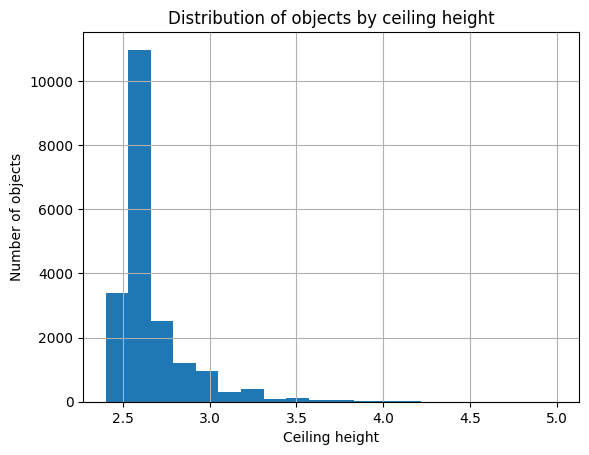

In [47]:
plt.xlabel('Ceiling height')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by ceiling height')
data['ceiling_height'].hist(bins=20, range=(2.4, 5))
data['ceiling_height'].describe()

In [48]:
data.sort_values(by='ceiling_height', ascending=False)[['ceiling_height','total_area','floor']].head(20)

,ceiling_height,total_area,floor
22739,100.0,25.0,5
22211,32.0,92.4,5
3134,32.0,75.0,2
21256,27.5,42.0,19
20364,27.0,45.0,2
5219,27.0,54.0,3
22807,27.0,98.0,2
21700,27.0,44.0,2
10713,27.0,58.0,3
5777,27.0,80.0,13


**It can be seen that ceiling height >= 20 meters (the first value of 100 meters will be discarded as an outlier) most likely corresponds to errors in the digit and should be divided by 10**

In [49]:
data.sort_values(by='ceiling_height', ascending=True)[['ceiling_height','total_area','floor']].head(5)

,ceiling_height,total_area,floor
22463,1.00,55.0,7
5683,1.20,42.8,1
16837,1.75,40.0,5
16357,2.00,88.3,2
18992,2.00,56.0,1


**Ceiling heights < 2 meters will be discarded as abnormally low, we will also leave NaN values, without them the sample will be greatly reduced.**

In [50]:
ceil_ids = data[data['ceiling_height'] >= 20].index
for id in ceil_ids:
    data.loc[id, 'ceiling_height'] /= 10

In [51]:
data = data[(data['ceiling_height'] >= 2) | (data['ceiling_height'].isna())]
data.shape[0]

20130

count    20130.000000
mean         2.687144
std          0.232846
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

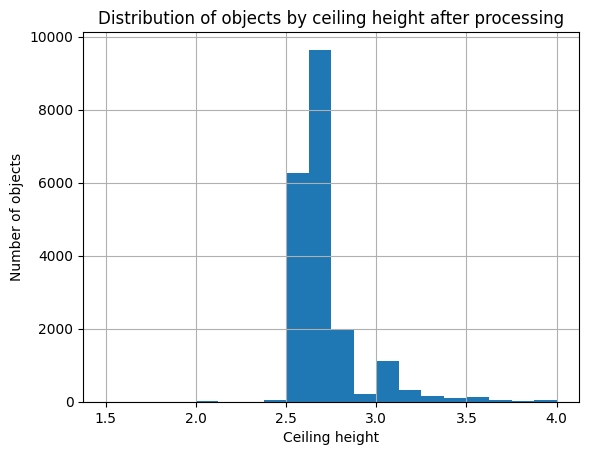

In [52]:
plt.xlabel('Ceiling height')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by ceiling height after processing')
data['ceiling_height'].hist(bins=20, range=(1.5, 4))
data['ceiling_height'].describe()

*Most properties in the sample have ceiling heights from 2.5 to 3 meters*

In [53]:
data.sort_values(by='ceiling_height', ascending=False)[['ceiling_height','total_area','floor']].head(5)

,ceiling_height,total_area,floor
14975,14.0,56.4,5
22739,10.0,25.0,5
5833,8.3,45.0,14
3459,8.0,30.0,2
15656,8.0,67.0,1


**We will also discard ceiling heights >= 8, as they are more likely to be outliers.**

In [54]:
data = data[(data['ceiling_height'] < 8) | (data['ceiling_height'].isna())]
data.shape[0]

20125

**Intermediate conclusions on ceiling_height: in the raw data, there were abnormally large ceiling heights > 20 meters, which are most likely due to incorrectly filled fields, we corrected them by dividing by 10. Most properties in the sample have ceiling heights from 2.5 to 3 meters, but there are rare very large values > 8 m. The median is 2.6 meters.**

##### floor_type

In [55]:
data.groupby('floor_type')['floor_type'].count()

floor_type
first     2505
last      2835
other    14785
Name: floor_type, dtype: int64

In [56]:
data.shape[0]

20125

<Axes: title={'center': 'Distribution of objects by floor type'}, xlabel='floor_type', ylabel='Number of objects'>

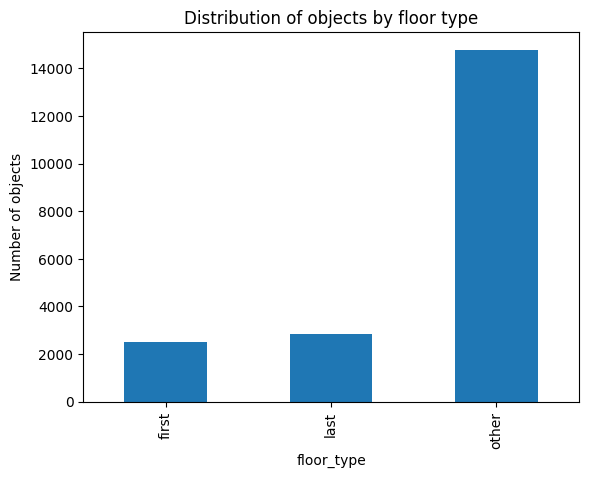

In [57]:
plt.xlabel('Floor type')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by floor type')
data.groupby('floor_type')['floor_type'].count().plot(kind='bar')

**Nothing abnormal was noticed in the distribution by floor type**

**Intermediate conclusions on floor_type: in our sample, objects are present in roughly equal numbers on the first and last floors of the building. The type of intermediate floors predominates, which is quite logical.**

##### floors_total

count    20125.000000
mean        10.626087
std          6.544404
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64

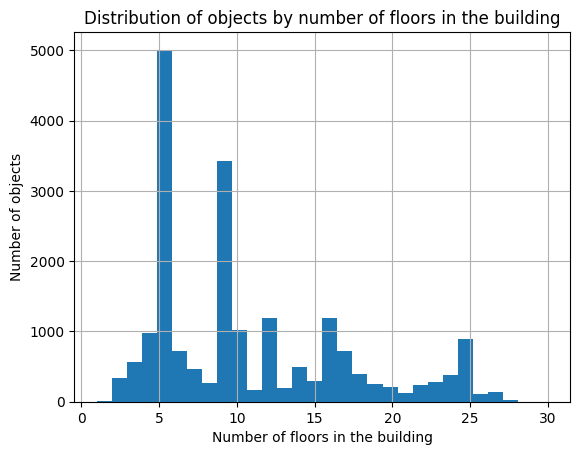

In [58]:
plt.xlabel('Number of floors in the building')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by number of floors in the building')
data['floors_total'].hist(bins=30, range=(1, 30))
data['floors_total'].describe()

**The distribution of the number of floors in buildings has clear peaks at 5 and 9 floors, which is typical for this region.**

In [59]:
data.sort_values(by='floors_total', ascending=False)[['floors_total','floor']].head(10)

,floors_total,floor
2245,60,4
16635,52,18
11017,36,29
5777,36,13
395,36,28
4831,35,4
15894,35,9
1911,35,30
1056,35,15
867,35,23


In [60]:
data.sort_values(by='floors_total', ascending=True)[['floors_total','floor']].head(5)

,floors_total,floor
8347,1,1
4358,1,1
5670,1,1
19481,1,1
16355,1,1


**The distribution and values of the number of floors will be left unchanged, no abnormal values were noticed.**

**Intermediate conclusions on floors_total: in our data, the distribution of the number of floors in buildings has clear peaks at 5 and 9 floors, which is typical for this region. There are also single options with a very large number of floors > 30. The median number of floors is 9.**

##### cityCenters_nearest

count    15508.000000
mean     14576.745486
std       8639.401982
min        208.000000
25%       9961.750000
50%      13301.000000
75%      16431.250000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

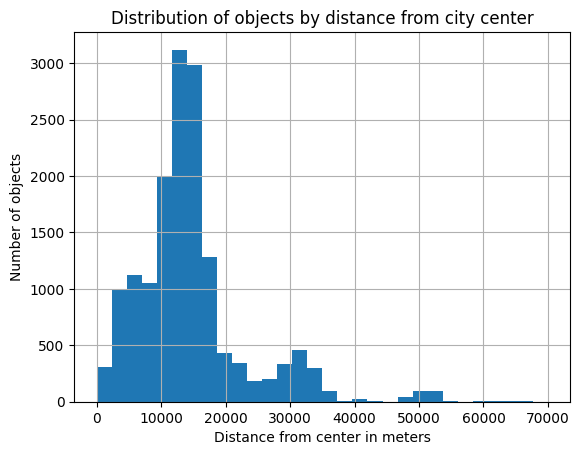

In [61]:
plt.xlabel('Distance from center in meters')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by distance from city center')
data['cityCenters_nearest'].hist(bins=30, range=(1, 70000))
data['cityCenters_nearest'].describe()

In [62]:
data.sort_values(by='cityCenters_nearest', ascending=False)[['cityCenters_nearest','locality_name']].head(10)

,cityCenters_nearest,locality_name
9594,65968.0,поселок Молодежное
5313,65952.0,поселок Молодежное
574,65764.0,поселок Молодежное
20629,65105.0,поселок Молодежное
5191,64857.0,поселок Молодежное
18780,62706.0,Зеленогорск
2961,62454.0,Зеленогорск
16476,61495.0,Ломоносов
22992,60223.0,Ломоносов
4420,59626.0,Зеленогорск


In [63]:
data.sort_values(by='cityCenters_nearest', ascending=True)[['cityCenters_nearest','locality_name']].head(10)

,cityCenters_nearest,locality_name
1177,208.0,Санкт-Петербург
8571,215.0,Санкт-Петербург
1927,287.0,Санкт-Петербург
20756,291.0,Санкт-Петербург
21911,329.0,Санкт-Петербург
8634,376.0,Санкт-Петербург
8198,387.0,Санкт-Петербург
16981,392.0,Санкт-Петербург
2599,399.0,Санкт-Петербург
12485,423.0,Санкт-Петербург


**No abnormal values were found, this item was filled in automatically**

**Intermediate conclusions on cityCenters_nearest: only 15508 objects are considered close enough to the center to not have a missing value in this parameter. Most objects are located less than 20 km from the city center. There are objects located right in the center, as well as single options at a great distance > 50 km from the center, options with NaN in cityCenters_nearest are probably even further, as this item was filled in automatically based on geographic data. The median is ~13 km.**

##### parks_nearest

count    6721.000000
mean      490.952537
std       335.708207
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

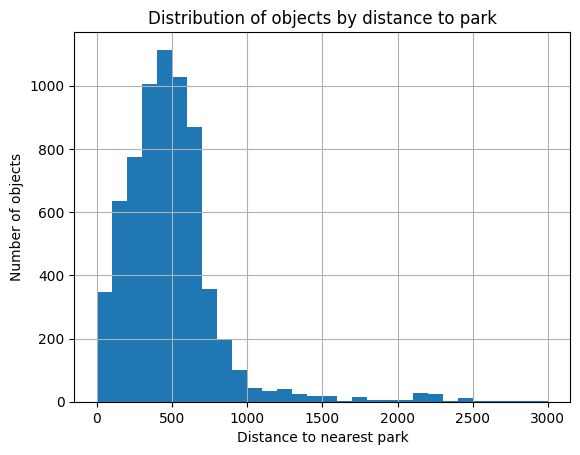

In [64]:
plt.xlabel('Distance to nearest park')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by distance to park')
data['parks_nearest'].hist(bins=30, range=(1, 3000))
data['parks_nearest'].describe()

In [65]:
data.sort_values(by='parks_nearest', ascending=False)[['parks_nearest','parks_around3000']].head(10)

,parks_nearest,parks_around3000
10898,3190.0,0
19322,3190.0,0
1585,3064.0,0
19101,3013.0,0
22949,2984.0,1
2648,2905.0,1
1854,2888.0,1
7815,2880.0,1
3847,2847.0,1
21878,2768.0,1


In [66]:
data.sort_values(by='parks_nearest', ascending=True)[['parks_nearest','parks_around3000']].head(10)

,parks_nearest,parks_around3000
14539,1.0,1
11881,3.0,1
9299,7.0,1
2518,9.0,3
4449,10.0,1
18987,10.0,1
21649,10.0,1
15210,10.0,1
188,10.0,1
7748,10.0,2


**No abnormal values were found, this item was filled in automatically**

**Intermediate conclusions on parks_nearest: only 6721 entries have a park close enough for the system to fill in this parameter. Of all these entries, the closest are located directly in the park or on its border, and the farthest at a distance of ~3 km. The median distance is 456 m.**

#### Analysis of apartment sale speed

count    17441.000000
mean       182.451178
std        218.709469
min          1.000000
25%         44.000000
50%        100.000000
75%        234.000000
max       1580.000000
Name: days_exposition, dtype: float64

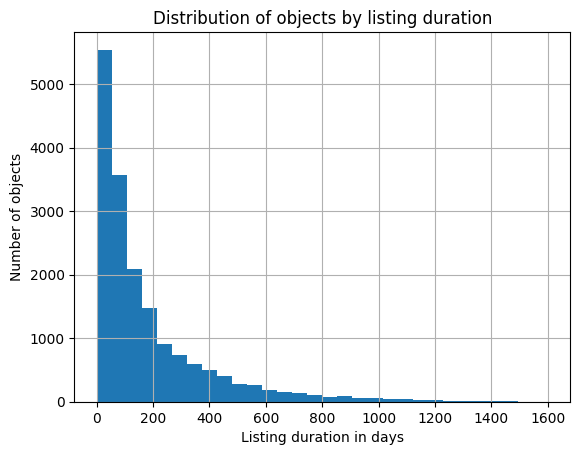

In [67]:
plt.xlabel('Listing duration in days')
plt.ylabel('Number of objects')
plt.title('Distribution of objects by listing duration')
data['days_exposition'].hist(bins=30, range=(1, 1600))
data['days_exposition'].describe()

<Axes: title={'center': 'Boxplot of listing duration'}>

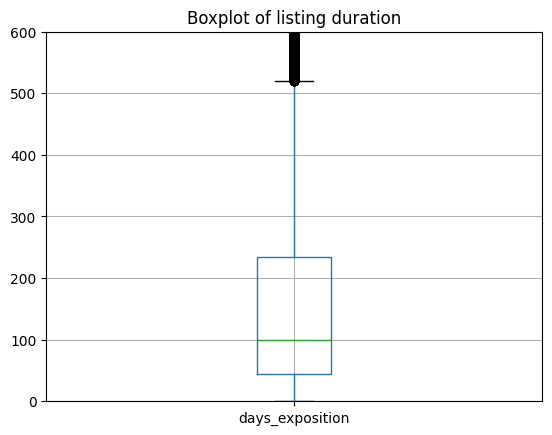

In [68]:
plt.title('Boxplot of listing duration')
plt.ylim(0, 600)
data.boxplot(column='days_exposition')

***Average apartment sale time: 183 days***

***Median sale time: 100 days, and since there are large values in this category that skew the mean upwards, the median is more correct to show how long a sale usually takes.***

***Exceptionally long sales can be considered those greater than the upper bound of the boxplot, i.e., Q3 + 1.5*Q3, from describe() Q3 is 234 days, so 234*2.5 = 608.4 days.***

***Quick sales can be considered those faster than the first quartile (Q1), from describe() it is 44 days.***

#### Factors that most influence the total value of the property

##### total_area

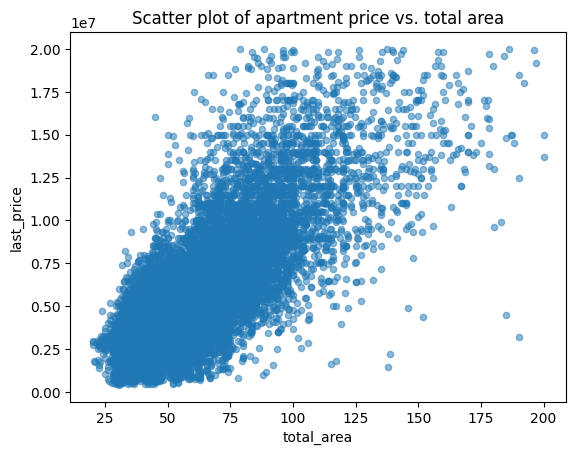

In [69]:
data.plot(
    x='total_area',
    y='last_price',
    kind='scatter', 
    title='Scatter plot of apartment price vs. total area',
    alpha=0.5
)
print()

**A general logical trend of price increasing with apartment area can be seen. We can also present this relationship using a pivot table.**

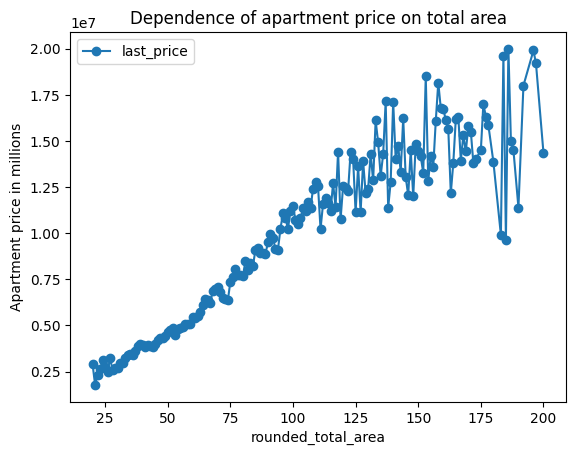

In [70]:
data['rounded_total_area'] = data['total_area'].round()
(
    data.pivot_table(index='rounded_total_area', values='last_price').
    plot(style='-o',title='Dependence of apartment price on total area', ylabel='Apartment price in millions')
)
print()

##### living_area

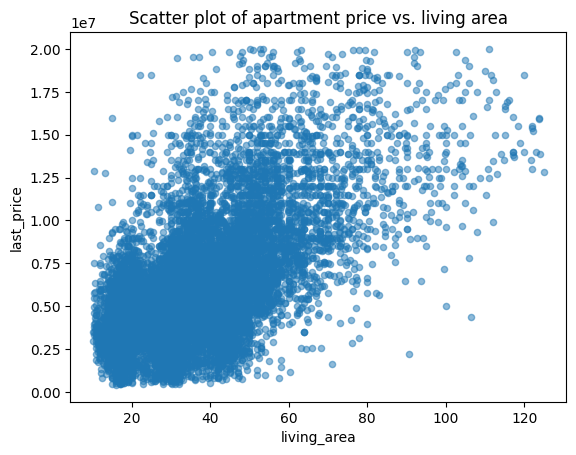

In [71]:
data.plot(
    x='living_area',
    y='last_price',
    kind='scatter', 
    title='Scatter plot of apartment price vs. living area',
    alpha=0.5
)
print()

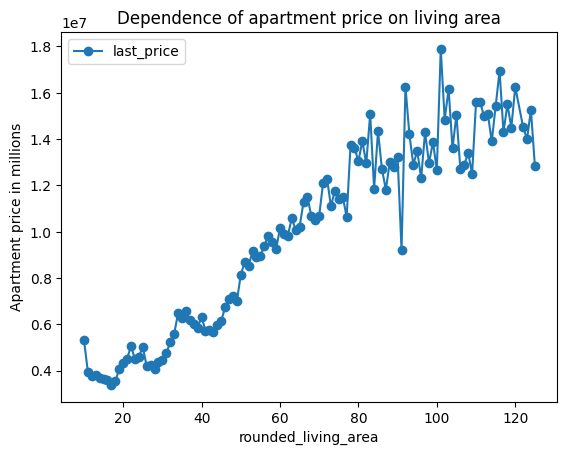

In [72]:
data['rounded_living_area'] = data['living_area'].round()
(
    data.pivot_table(index='rounded_living_area', values='last_price').
    plot(style='-o',title='Dependence of apartment price on living area', ylabel='Apartment price in millions')
)
print()

**As with total area, living area is directly proportional to apartment price**

##### kitchen_area

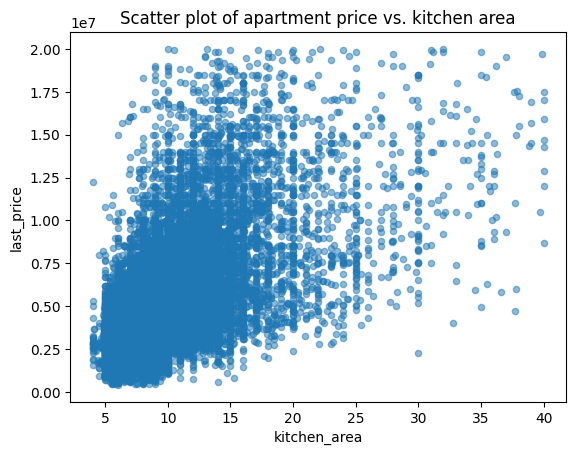

In [73]:
data.plot(
    x='kitchen_area',
    y='last_price',
    kind='scatter', 
    title='Scatter plot of apartment price vs. kitchen area',
    alpha=0.5
)
print()

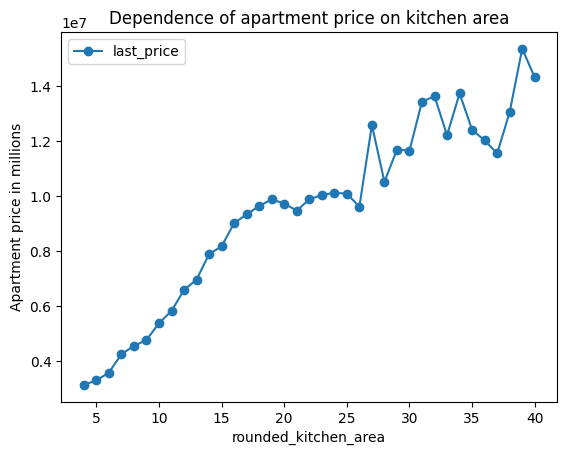

In [74]:
data['rounded_kitchen_area'] = data['kitchen_area'].round()
(
    data.pivot_table(index='rounded_kitchen_area', values='last_price').
    plot(style='-o',title='Dependence of apartment price on kitchen area', ylabel='Apartment price in millions')
)
print()

**Kitchen area is directly proportional to apartment price**

##### rooms

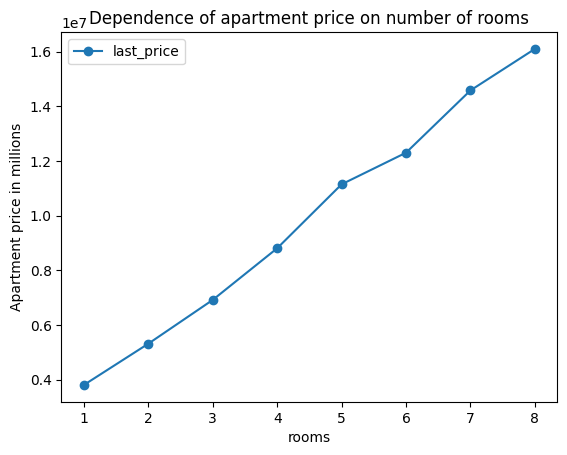

In [75]:
(
    data.pivot_table(index='rooms', values='last_price').
    plot(style='-o',title='Dependence of apartment price on number of rooms', ylabel='Apartment price in millions')
)
print()

In [76]:
feature_arr = []
corr_arr = []
for feature in data.select_dtypes(include='number').columns:
    print(f"Correlation coefficient between last_price and {feature}: {data['last_price'].corr(data[feature])}")
    feature_arr.append(feature)
    corr_arr.append(data['last_price'].corr(data[feature]))
corr_df = pd.DataFrame( {'corr_value': corr_arr}, index = feature_arr)

Correlation coefficient between last_price and total_images: 0.16100825240796385
Correlation coefficient between last_price and last_price: 1.0
Correlation coefficient between last_price and total_area: 0.7706492069285104
Correlation coefficient between last_price and rooms: 0.49937109147450676
Correlation coefficient between last_price and ceiling_height: 0.423766106174931
Correlation coefficient between last_price and floors_total: 0.13756048991846553
Correlation coefficient between last_price and living_area: 0.6567532960213213
Correlation coefficient between last_price and floor: 0.10553082912573471
Correlation coefficient between last_price and kitchen_area: 0.5727017791818071
Correlation coefficient between last_price and balcony: 0.04976339045922206
Correlation coefficient between last_price and airports_nearest: -0.039996129944252695
Correlation coefficient between last_price and cityCenters_nearest: -0.35992991428091275
Correlation coefficient between last_price and parks_arou

<Axes: title={'center': 'Correlation of property parameters with their price'}, ylabel='correlation coefficient'>

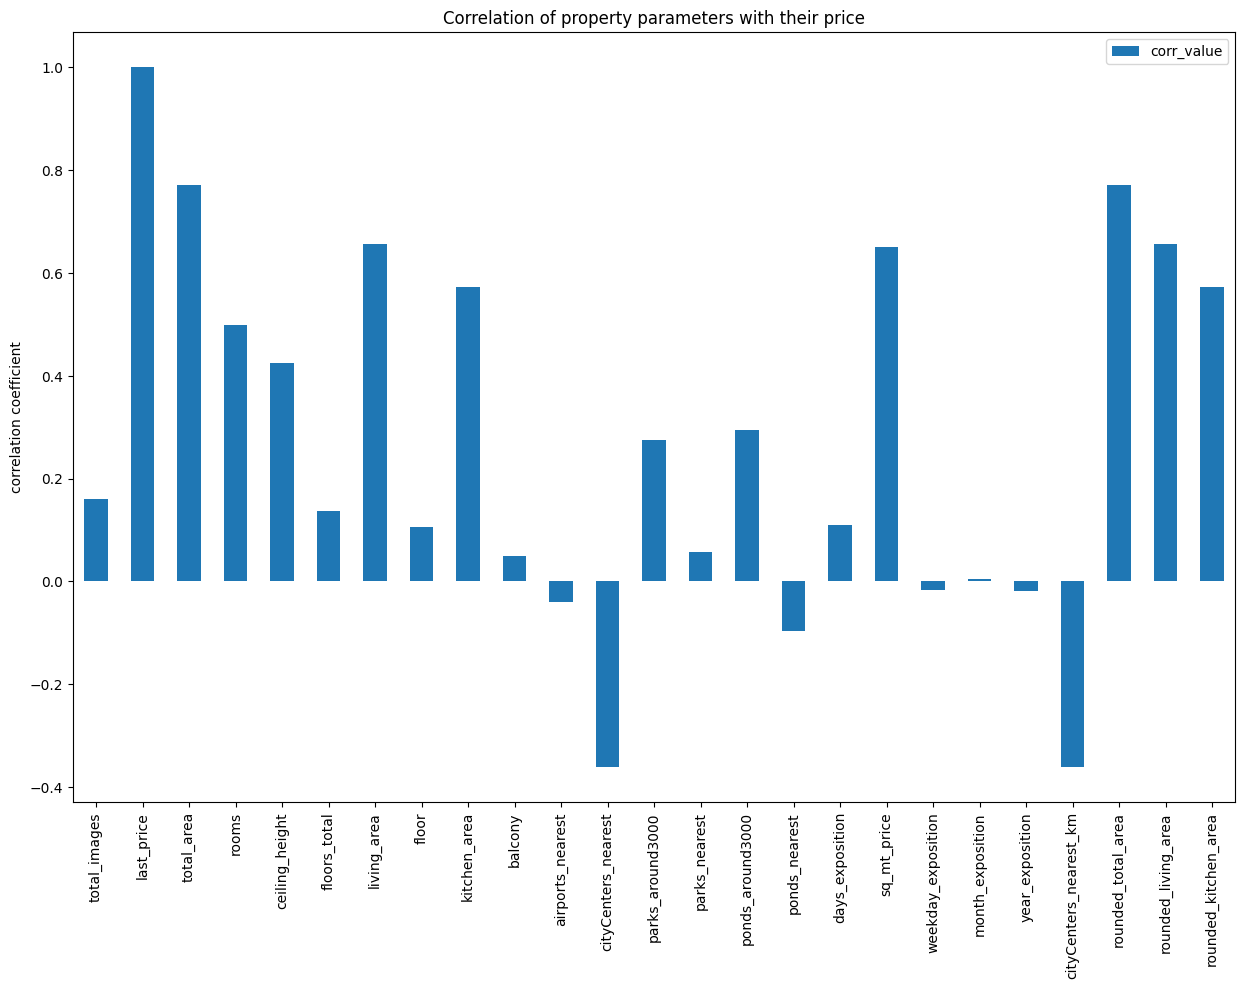

In [77]:
corr_df.plot(
    kind='bar', 
    figsize=(15,10),
    ylabel='correlation coefficient',
    title='Correlation of property parameters with their price'
)

**The graph shows the following conclusions: distance to the center is inversely proportional to the price of the object, other parameters are directly proportional. The highest correlation coefficient is for total area, living area, and kitchen area. There is no point in discussing auxiliary columns that are rounded values of area, as well as distance to the center in kilometers, these are the same features.**

**Additionally, we calculated correlation coefficients, from which we can conclude that all these parameters are directly proportional to the apartment price, and the total area of the object has the greatest influence on it.**

**The number of rooms is directly proportional to the price.**

##### floor_type

To assess this parameter, we should first group real estate by the number of floors, calculate the average values for all floor_type types, and then plot a graph to compare the influence of floor type in different buildings.

In [78]:
data_floors = (
    data.groupby(['floor_type','floors_total'])['last_price']
    .mean().unstack().reset_index().round(1).T
    .rename(columns={0: 'other', 1: 'first',2 : 'last'})
    .drop(['floor_type'])
)
data_floors.head()

,other,first,last
floors_total,,,
1,2934411.8,NaN,NaN
2,2535024.0,3069233.5,NaN
3,4465995.4,5227089.7,4962155.6
4,5201415.3,6551857.8,6510580.4
5,3950297.8,4326235.8,4601044.3


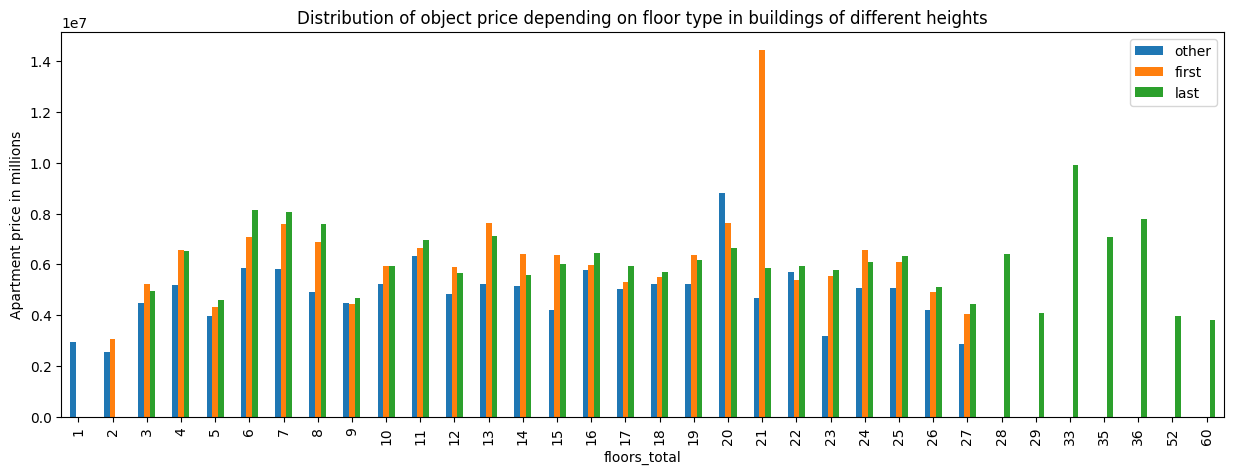

In [79]:

data_floors.plot(kind='bar', figsize=(15,5), ylabel='Apartment price in millions')
plt.title('Distribution of object price depending on floor type in buildings of different heights')
print()

**From this graph, we can conclude that the price of an apartment on the first floor (orange bar) is usually lower than the price of an apartment on the last (green bar) or any other (blue bar). Except for the abnormally high peak in a building with 21 floors, the prices of apartments on the last or intermediate floors do not differ much. For buildings with floors_total > 27, there are no listings with all floor types**

##### first_day_exposition and related features

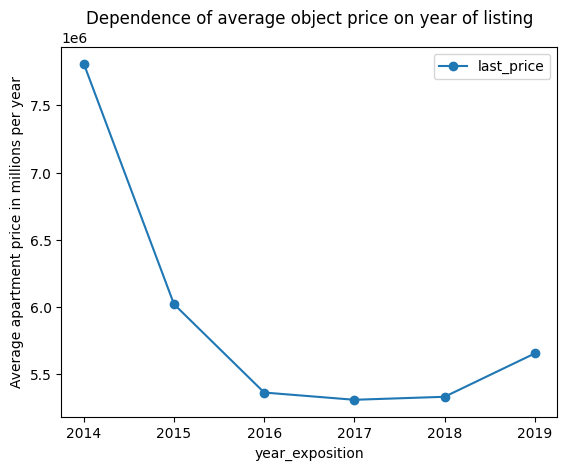

In [80]:

(
    data.pivot_table(index='year_exposition', values='last_price', aggfunc='mean')
    .plot(style='-o', ylabel='Average apartment price in millions per year')
)
plt.title('Dependence of average object price on year of listing')
print()

*In 2014 and 2015, it was more expensive to buy an apartment than in 2016-2019*

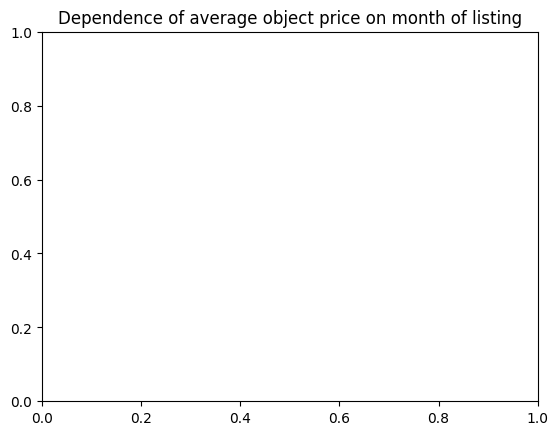

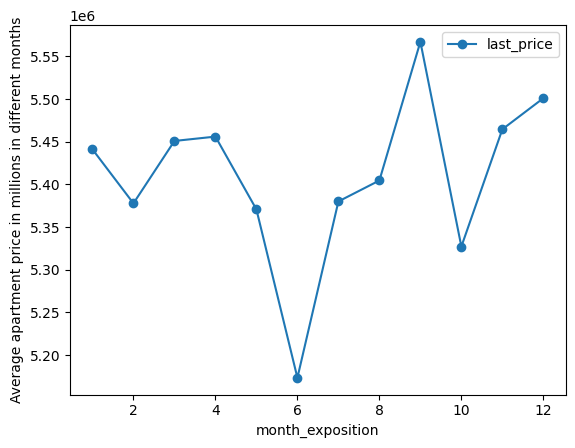

In [81]:
plt.title('Dependence of average object price on month of listing')
(
    data.pivot_table(index='month_exposition', values='last_price', aggfunc='mean')
    .plot(style='-o', ylabel='Average apartment price in millions in different months')
)
print()

*The "cheapest" month to buy an apartment is June, and the "most expensive" is September*

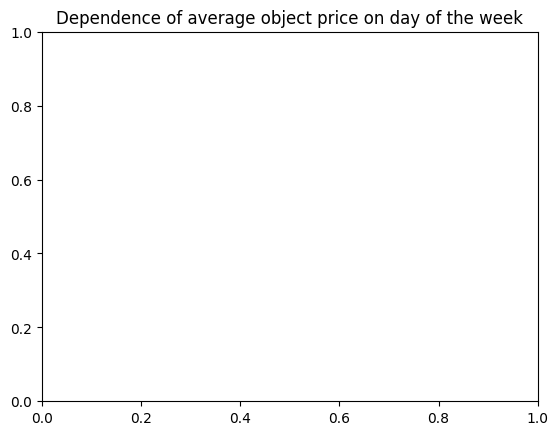

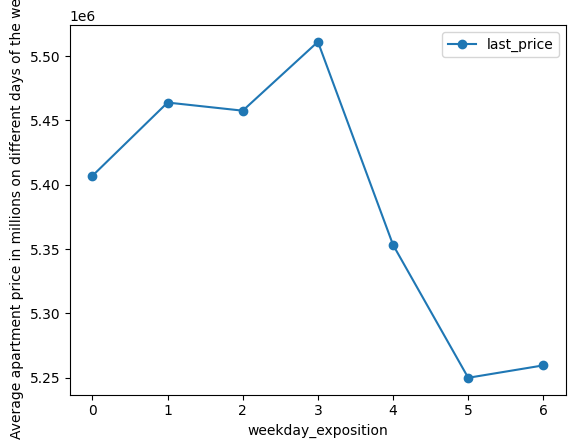

In [82]:
plt.title('Dependence of average object price on day of the week')
(
    data.pivot_table(index='weekday_exposition', values='last_price', aggfunc='mean')
    .plot(style='-o', ylabel='Average apartment price in millions on different days of the week')
)
print()

*The cheapest apartments were bought on Saturday, and the most expensive on Thursday.*

**Summary: after analyzing the features that affect property prices, we can draw the following conclusions:**
   * The total area of the object has the greatest influence on the price, the larger the area, the higher the price
   * The only feature that decreases the price as it increases is the distance to the center, the farther away, the cheaper the object
   * The "cheapest" month to buy an apartment is June, and the "most expensive" is September
   * In 2014 and 2015, it was more expensive to buy an apartment than in 2016-2019
   * The price of an apartment on the first floor is usually lower than on the last or any other floor.

#### Analysis of the price per square meter in the most popular localities by number of listings

In [83]:
data_sqmt = data.pivot_table(index='locality_name', values='sq_mt_price', aggfunc=['count','mean'])
data_sqmt

,count,mean
,sq_mt_price,sq_mt_price
locality_name,,
Бокситогорск,10,16910.915000
Волосово,35,40144.608000
Волхов,91,35120.871319
Всеволожск,356,67424.112978
Выборг,189,58261.619365
...,...,...
село Путилово,2,39921.755000
село Рождествено,2,34553.885000


In [84]:
data_sqmt.columns = ['count', 'mean']
data_sqmt = (
    data_sqmt.sort_values(by='count',ascending=False).
    reset_index()
)
data_sqmt

,locality_name,count,mean
0,Санкт-Петербург,13306,107967.023719
1,поселок Мурино,424,85099.703090
2,поселок Шушары,391,78422.055243
3,Всеволожск,356,67424.112978
4,Пушкин,323,102122.649009
...,...,...,...
305,поселок Барышево,1,31250.000000
306,деревня Зимитицы,1,31896.550000
307,поселок Алексеевка,1,22222.220000
308,поселок Александровская,1,63559.320000


In [85]:
data_sqmt = data_sqmt.iloc[:10]
data_sqmt.sort_values(by='mean', ascending=False)

,locality_name,count,mean
0,Санкт-Петербург,13306,107967.023719
4,Пушкин,323,102122.649009
8,деревня Кудрово,225,92234.697911
7,поселок Парголово,288,90756.002986
1,поселок Мурино,424,85099.703090
2,поселок Шушары,391,78422.055243
5,Колпино,321,75129.845452
6,Гатчина,290,68635.620586
3,Всеволожск,356,67424.112978
9,Выборг,189,58261.619365


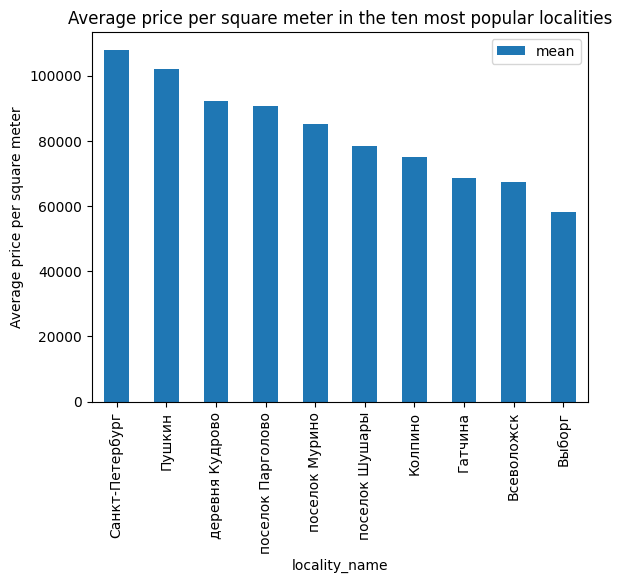

In [86]:

data_sqmt.sort_values(by='mean', ascending=False).plot(
    x='locality_name', 
    y='mean',
    kind='bar',
    ylabel='Average price per square meter',
    title='Average price per square meter in the ten most popular localities'
)
print()

**The highest price per square meter is in St. Petersburg, and the lowest is in Vyborg**

#### Dependence of price on distance to the center of St. Petersburg

TypeError: no numeric data to plot

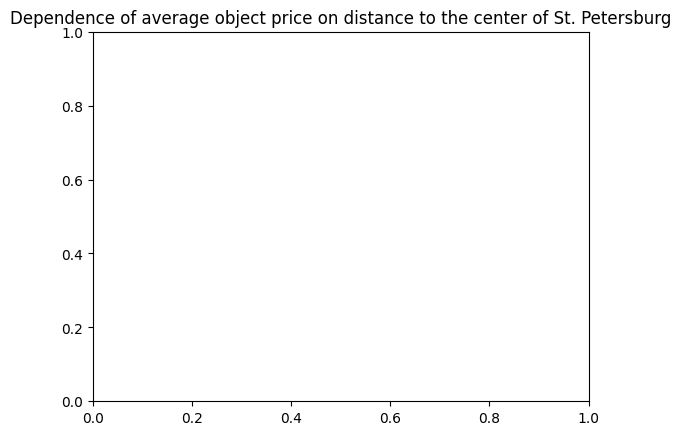

In [87]:
plt.title('Dependence of average object price on distance to the center of St. Petersburg')
data_spb = data.query('locality_name == "St. Petersburg"')
(
    data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
    .plot(style='-o', ylabel='Average apartment price in millions per year')
)
print()

**We can conclude that the farther from the center the object is, the less it will cost.**

In [ ]:
data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')

,last_price
cityCenters_nearest_km,
0.0,1.007333e+07
1.0,1.056235e+07
2.0,9.896243e+06
3.0,8.911980e+06
4.0,9.199176e+06
5.0,9.146181e+06
6.0,8.390334e+06
7.0,7.886114e+06
8.0,7.841679e+06


**At 27 kilometers from the city, there is a strange outlier, most likely characterized by a single object with a high price**

In [ ]:
data_spb.query('27 <= cityCenters_nearest_km < 28')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,sq_mt_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km,rounded_total_area,rounded_living_area,rounded_kitchen_area
744,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,128.0,193918.92,1,11,2017,другой,27.0,74.0,30.0,25.0
5930,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,False,...,178.0,70312.50,1,2,2018,последний,27.0,32.0,16.0,7.0


**As expected, the object with index 748 strongly outweighs the average price at the 27th kilometer**

*Additionally, we can calculate the decrease in object price per kilometer from the center as the average value of the differences between neighboring values*

In [ ]:
val_arr = (
    data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean').
    last_price.values
)
val_arr = np.diff(val_arr)
print(f'On average, for each kilometer from the center of St. Petersburg, apartment prices decrease by {abs(val_arr.mean()).round()} rubles')

В среднем за каждый километр от центра Санкт-Петербурга стоимость квартир снижается на 188943.0 рублей


### General conclusion

**General conclusion:** 
Project goal: In this work, we process real estate sales statistics to find out which parameters affect the value of properties and how significant their contribution is.

* First, we simply evaluated the raw data for missing values and looked at the distributions in the columns. The histograms showed the presence of large "tails" in many features, as well as missing values in 14 columns.

* Then an analysis of missing values was carried out, its results:

**Summary of missing value processing**:
1. ceiling_height - leave missing values
1. floors_total - leave missing values
1. living_area - leave missing values 
1. is_apartment - replace with False
1. kitchen_area - leave missing values
1. balcony - replace with 0
1. locality_name - leave missing values
1. airports_nearest - leave missing values
1. cityCenters_nearest - leave missing values
1. parks_around3000 - replace with 0
1. parks_nearest - leave missing values
1. ponds_around3000 - replace with 0
1. ponds_nearest  - leave missing values
1. days_exposition - possible replacement described above, leave missing values

**Possible reasons for missing data**:
1. ceiling_height - not specified by user, possibly difficult to measure
1. floors_total - not specified by user
1. living_area - not specified by user, possibly difficult to measure
1. is_apartment - not specified by user, missing values handled in preprocessing
1. kitchen_area - not specified by user, possibly difficult to measure
1. balcony - not specified by user, missing values handled in preprocessing
1. locality_name - not specified by user, possibly property is outside settlements (e.g., a house in the forest)
1. airports_nearest - filled automatically, most likely the nearest airport is quite far
1. cityCenters_nearest - filled automatically, most likely the nearest center is quite far or the settlement is small and does not have a clearly defined center
1. parks_around3000 - filled automatically, most likely there are no parks nearby, missing values handled in preprocessing
1. parks_nearest - filled automatically, most likely the nearest park is quite far
1. ponds_around3000 - filled automatically, most likely there are no ponds nearby, missing values handled in preprocessing
1. ponds_nearest - filled automatically, most likely the nearest pond is quite far
1. days_exposition - most likely the column with the number of days the listing was posted before it was removed was filled in automatically, and NaN values mean that at the time of data collection, the listing was still active

* The column with the listing date was corrected, converted to Datetime format for easier work with it. Columns with integer values without missing values were also converted to int to save memory.

* The next step was to search for duplicates, in which we replaced all prefixes of localities with the same values, such as: "urban-type settlement", "urban settlement", "village", etc. with the more general "settlement" to avoid confusion with implicit duplicates.

* The following columns were added and filled in the table:
       * price per square meter;
       * day of the week the listing was posted (0 - Monday, 1 - Tuesday, etc.);
       * month of the listing;
       * year of the listing;
       * floor type ("first", "last", "other");
       * distance to the city center in kilometers.
       
* At this point, preprocessing was completed, and as part of exploratory analysis, we examined the parameters described below and filtered out rare and outlier values, as well as corrected some obvious data entry errors:
  - total area (kept values < 200 and > 20); 
  - living area (kept values < 125 and > 10, corrected 5 likely typos);
  - kitchen area (kept values < 40 and > 4);
  - object price (kept values less than 20 million);
  - number of rooms (left unchanged);
  - ceiling height (kept values < 8 and > 2, corrected obvious typos);
  - floor type (no anomalies found);
  - total number of floors in the building (left unchanged);
  - distance to the city center in meters (left unchanged, filled automatically);
  - distance to the nearest park (left unchanged, filled automatically).


* Then we studied the time to sell an object, found out how long it usually takes to sell an apartment.

    * Average apartment sale time: 183 days
    * Median sale time: 100 days, and since there are large values in this category that skew the mean upwards, the median is more correct to show how long a sale usually takes.

    * Exceptionally long sales can be considered those greater than 600 days

    * Quick sales can be considered those completed on the same day

* An assessment was made of the factors that affect the price of an apartment:
    * the following features are directly proportional to the price: 'total_area', 'living_area', 'kitchen_area', 'rooms', with the highest correlation coefficient for 'total_area'
    * for the 'floor_type' feature, the analysis showed that apartments on the first floor are usually cheaper than those on the last or any intermediate floor. There is no clear difference between the price of an apartment on the last floor and any intermediate floor.
    * The dependence of apartment price on the listing date and its individual characteristics (year, month, day of the week) was analyzed. The following conclusions were made: in 2014 and 2015, it was more expensive to buy an apartment than in 2016-2019, the "cheapest" month to buy an apartment is June, and the "most expensive" is September, the cheapest apartments were bought on Saturday, and the most expensive on Thursday.

* The price per square meter was studied in the 10 most popular localities by number of listings. The highest price per square meter (108,000 rubles) is in St. Petersburg, and the lowest (58,261 rubles) is in Vyborg

* For real estate in St. Petersburg, a table was compiled and visualized showing the dependence of object price on its distance from the city center. On average, for each kilometer from the center of St. Petersburg, apartment prices decrease by 188,943 rubles.

In conclusion, a user who wants to save money when buying an apartment should look for an apartment on the first floor, farther from the city center, and preferably not in St. Petersburg.